# Problem 1

## 1.1 Running the 11.py document with amin=-6 , ß=1, r=0

In [2]:

#Load libraries
import time                      #Measure time
import math                      #Mathematical library 
import numpy as np               #Load numpy
import matplotlib.pyplot as plt  #Load matplotlib for graphs

# Data structure of state and exogenous variables
class modelState(object):
    def __init__(self,
                 NA=501,      #Gridpoints of assets grid
                 T=10,        #Age at death
                 Tr=8,        #Age at retirement
                 α=2,         #Degree of relative risk aversion
                 β=1,      #Discount factor
                 r=0,#Interest rate
                 amin=-6.0,    #Lower bound of assets'grid
                 amax=6.0):   #Higher bound of assets'grid

        #Initialize arrays
        V = np.zeros((T, NA))                     #Initialize Value function 
        opt_ia = np.zeros((T, NA),dtype=np.int32) #Initialize optimal savings
        A=np.linspace(amin,amax,NA)               #Build grid for assets
        y=np.zeros(T)                             #Initialize income grid
        for t in range(Tr):y[t]=1+t*0.5           #Assign income over life
            
        # Store grids and parameters
        self.NA = NA;self.T = T;self.Tr=Tr;self.A = A;self.α = α;
        self.β=β ;self.y = y;self.r = r;self.V = V;self.opt_ia=opt_ia
        
# Import all the parameters
st=modelState()          

# Define the utility function
def u(c,st):
    
    if c<=0: return math.pow(-10.0, 5)  #Assign very low utility if c<=0
    
    if(st.α!=1):
        u=math.pow(c,(1-st.α))/(1-st.α) #Power utility function if α!=1
    else: 
        u=np.log(c)                     #Power utility function when α=1
    
    return u
    
# Function that returns value and policy functions for a given state (t,ia)
def value_func(st,t,ia):                      #max util given age t, assets ia
    
    Vf=math.pow(-10.0, 5)                     #Initialize the value function
    o_ia=0                                    #Initialize policy function
    
    #Find policy function (optimal savings) if t==T-1
    if(t>=st.T-1):
        o_ia=np.searchsorted(st.A,0)          #Why? Cannot die with debt!
        Vf=u((1+st.r)*st.A[ia]+st.y[t],st)    #Terminal condition: consume...
        return Vf,o_ia                        #..everything before dying!
       
    #Find policy function (optimal savings) if t<T-1
    for iap in range(st.NA):                  #Loop over future assets to...
                                              #...find the optimal one!  
        c=(1+st.r)*st.A[ia]+st.y[t]-st.A[iap] #Given iap, get consumption c     
        util=u(c,st)+st.β*st.V[t+1, iap]      #Obtain utility of choosing iap 
            
        if(util >= Vf):Vf = util; o_ia = iap  #Update V and optimal policy...
                                              #..if iap improves current util
    return Vf,o_ia                            #Return value and policy function        
#Compute value and policy functions for (t,ia) by backward induction
for t in reversed(range(st.T)):  #Loop over (reversed) age t
    for ia in range(st.NA):      #Loop over initial assets ia
            
            #Invoke the function "value_func" to obtain current policy and...
            #...value functions. Note that we already know V[t+1,:]!
            st.V[t, ia],st.opt_ia[t, ia]=value_func(st,t,ia)

#Initialize path of indexed assets. This also gives the initial condition...
#..which is the smallest gridpoint where assets are zero or positive
iA_path=np.zeros(st.T,dtype=np.int32)+np.searchsorted(st.A,0)

#Use policy function for getting assets path over life. Leave t=0.
for t in range(st.T-1):iA_path[t+1]=st.opt_ia[t,iA_path[t]]

#Obtain path of assets: transform indexes in actual wealth using the grid
A_path=st.A[iA_path]

#Path for consumption: copy the exogenous wages over time
y_path=st.y

#Use the policy function + budget constraint to get optimal consumption
c_path=np.ones(st.T)*(1+st.r)*A_path[st.T-1]+y_path[st.T-1]
for t in range(st.T-1):c_path[t]=(1+st.r)*A_path[t]+y_path[t]-A_path[t+1]

### Plots

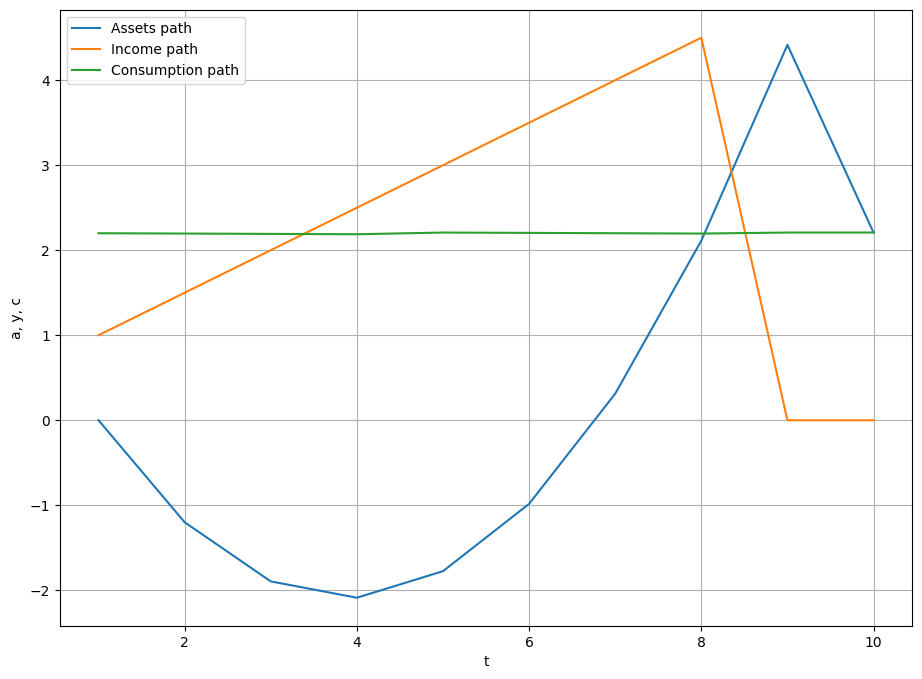

In [3]:
fig, ax = plt.subplots(figsize=(11, 8))   #Initialize figure and size
ax.plot(np.cumsum(np.ones(st.T)), A_path, label="Assets path") 
ax.plot(np.cumsum(np.ones(st.T)), y_path, label="Income path") 
ax.plot(np.cumsum(np.ones(st.T)), c_path, label="Consumption path")
ax.grid()
ax.set_xlabel('t')                        #Label of x axis
ax.set_ylabel('a, y, c')                  #Label of y axis
plt.legend()                              #Plot the legend
plt.show()                                #Show the graph


Comments about the consumption path etc...

## 1.2 doing it with pen and paper

We have the following maximisation problem:

$$
\Sigma_{t=0}^{T} \beta^t \Big( \frac{c_t^{1-\alpha}}{1-\alpha} + \lambda_t((1+r)a_t+y_t-c_t-a_{t+1}) \Big)
$$
$$
\frac{\partial L }{\partial c_t}: c^{-\alpha}=\lambda_t \\
$$
$$
\frac{\partial L }{\partial a_{t+1}}: \lambda_t=\beta (1+r) \lambda_{t+1}
$$


Since $\lambda = c$ we can combine these two derivatives into an equation and get:\\
$$ c_t=\beta (1+r) c_{t+1}\\
c_t= c_{t+1}
$$
So the consumption over all the periods are equal.

Now that we have this equality, lets go back to the intertemporal budget constraint of the problem and expand it:
$$
a_1=a_0+y_0 + c\\
a_2=a_1+y_1 + c\\
...\\
a_{T+1}=a_{T}+ y_T + c $$
Summing these budget constraints we obtain:
$$ a_{T+1}=a_{0}+\Sigma y_t + T*c$$ Now we know that consumers consume everything in the last period and start their lives with 0 assets, we are left with this equation. $ \Sigma y_t = T*c$, $y_t$ is following a stochastic growth as given in the function as $y_t=1+0.5*t$ therefore the calculation of $y_t$ is trivially 22. And since the consumer lives for 10 periods we obtain the final equation:
$$ 22=10c$$
$$c_t=2.2$$ 

Now lets compare it with the computer results.

In [4]:
c_path.sum()

22.0

We can see that the summation of the consumption path is indeed 22 however if we take a look at the path c is not always 2.2

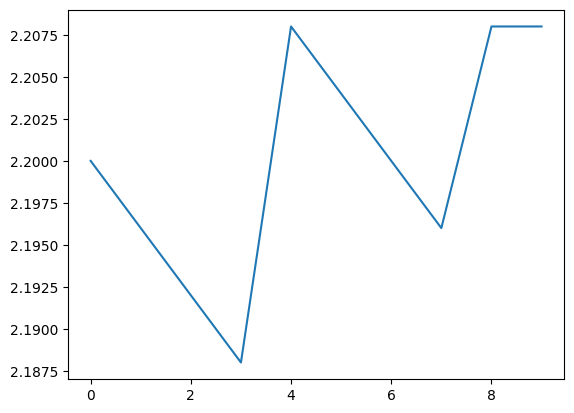

In [5]:
plt.plot(c_path)
plt.show()
